# Study on best models for transfer learning

In [1]:
#General imports

import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#For Path
from pathlib import Path

#For metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

#NN-related
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator #for fow from folder and data augmentation


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.13.0


# Global parameters 

In [ ]:
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64

IMG_SIZE = (96,96)
INPUT_SHAPE =  (96,96,3)
N_CLASSES = 2

SEED = 42
DATASET_DIR = '/kaggle/input/dataset2/training_data_final'
EPOCHS = 40

MY_METRIC='binary_accuracy'
MY_PATIENCE=20

tf.random.set_seed(SEED)

# Instantiate the dataset generators

We use a 0.8-0.2 train test split

In [ ]:

training_set = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    labels='inferred',
    label_mode='binary',
    class_names = None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset='training'
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    labels='inferred',
    label_mode='binary',
    class_names = None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset='validation'
)

## Enable mixed precision

In [ ]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

if tf.keras.mixed_precision.global_policy().name == 'mixed_float16':
    print("Mixed precision is enabled.")
else:
    print("Mixed precision is not enabled.")

## Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),  
  tf.keras.layers.RandomRotation(0.125), 
  tf.keras.layers.RandomBrightness(-0.2), 
  tf.keras.layers.RandomZoom((-0.20, 0.45), fill_mode='reflect'),
  tf.keras.layers.RandomTranslation(height_factor=0.25, 
                                    width_factor=0.25, 
                                    fill_mode='reflect')
], name='data_augmentation')


In [ ]:
OUTPUT_DIR = Path() / 'transfer_learning_models'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Define early stopping

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                                  mode='auto', 
                                                  patience=MY_PATIENCE, 
                                                  restore_best_weights=True)


# VGG16

In [ ]:
vgg16  = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)
vgg16.trainable = False

In [ ]:
inputs = keras.Input(shape=INPUT_SHAPE)

x = layers.Resizing(96, 96, interpolation='bicubic', name='resizing')(inputs)

x = data_augmentation (x)

x = keras.applications.vgg16.preprocess_input(x)

x = vgg16(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, 
                 kernel_initializer=keras.initializers.HeUniform(seed=SEED))(x)

x = layers.BatchNormalization()(x)

x = layers.Activation('relu')(x)

x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.GlorotUniform(seed=SEED))(x)

model_vgg16 = keras.Model(inputs, outputs)

chosen_opt = keras.optimizers.Adam(learning_rate=1e-3)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                                  mode='auto', 
                                                  patience=MY_PATIENCE, 
                                                  restore_best_weights=True)

model_vgg16.compile(loss=keras.losses.BinaryCrossentropy(), 
                    optimizer=chosen_opt, 
                    metrics=[MY_METRIC])

In [ ]:
history_VGG16 = model_vgg16.fit(training_set, 
                                epochs=EPOCHS, 
                                validation_data=validation_set, 
                                callbacks = [early_stopping],
                                verbose=1)

In [ ]:
np.save(str(OUTPUT_DIR / 'history_VGG16.npy'), history_VGG16.history)

## ConvNetXLarge

In [ ]:
ConvNeXtXLargemodel= tf.keras.applications.ConvNeXtXLarge(
    model_name="convnext_xlarge",
    include_top=False,
    include_preprocessing=True, #ragionare se lo vogliamo
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None 
)

ConvNeXtXLargemodel.trainable = False

In [ ]:
inputs = keras.Input(shape=INPUT_SHAPE)

x = layers.Resizing(96, 96, interpolation='bicubic', name='resizing')(inputs)

x = data_augmentation (x)

x = ConvNeXtXLargemodel(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, 
                 kernel_initializer=keras.initializers.HeUniform(seed=SEED))(x)

x = layers.BatchNormalization()(x)

x = layers.Activation('relu')(x)

x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, 
                       activation='sigmoid', 
                       kernel_initializer=keras.initializers.GlorotUniform(seed=SEED))(x)



model_ConvNetXLarge = keras.Model(inputs, outputs)

chosen_opt = keras.optimizers.Adam(learning_rate=1e-3)

model_ConvNetXLarge.compile(loss=keras.losses.BinaryCrossentropy(), 
                            optimizer=chosen_opt, 
                            metrics=[MY_METRIC])

In [ ]:
history_ConvNetXLarge = model_ConvNetXLarge.fit(training_set, 
                                epochs=EPOCHS, 
                                validation_data=validation_set, 
                                callbacks = [early_stopping],
                                verbose=1)


In [ ]:
np.save(str(OUTPUT_DIR / 'history_ConvNetXLarge.npy'), history_ConvNetXLarge.history)

## EfficientNetV2L

In [ ]:
EfficientNetV2Lmodel= tf.keras.applications.EfficientNetV2L(
    include_top=False,
    include_preprocessing=True, 
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None 
)

EfficientNetV2Lmodel.trainable = False


In [ ]:
inputs = keras.Input(shape=INPUT_SHAPE)

x = layers.Resizing(96, 96, interpolation='bicubic', name='resizing')(inputs)



x = data_augmentation (x)

x = keras.applications.efficientnet.preprocess_input(x)


x = EfficientNetV2Lmodel(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, kernel_initializer=keras.initializers.HeUniform(seed=SEED))(x)

x = layers.BatchNormalization()(x)

x = layers.Activation('relu')(x)

x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation='sigmoid', 
                       kernel_initializer=keras.initializers.GlorotUniform(seed=SEED))(x)


model_EfficientNetV2L = keras.Model(inputs, outputs)

In [ ]:
model_EfficientNetV2L

In [ ]:
chosen_opt = keras.optimizers.Adam(learning_rate=1e-3)

model_EfficientNetV2L.compile(loss=keras.losses.BinaryCrossentropy(), 
                              optimizer=chosen_opt, 
                              metrics=[MY_METRIC])

In [ ]:
history_EfficientNetV2L = model_EfficientNetV2L.fit(training_set, 
                                epochs=EPOCHS, 
                                validation_data=validation_set, 
                                callbacks = [early_stopping],
                                verbose=1)



In [ ]:
np.save(str(OUTPUT_DIR / 'history_EfficientNetV2L.npy'), history_EfficientNetV2L.history)

## NASNetLarge

In [ ]:
NASNetLargemodel= tf.keras.applications.NASNetLarge(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None 
)

NASNetLargemodel.trainable = False

In [ ]:
inputs = keras.Input(shape=INPUT_SHAPE)

x = layers.Resizing(96, 96, interpolation='bicubic', name='resizing')(inputs)

x = data_augmentation (x)

x = tf.keras.applications.nasnet.preprocess_input(x)

x = NASNetLargemodel(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, 
                 kernel_initializer=keras.initializers.HeUniform(seed=SEED))(x)

x = layers.BatchNormalization()(x)

x = layers.Activation('relu')(x)

x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.GlorotUniform(seed=SEED))(x)



model_NASNetLarge = keras.Model(inputs, outputs)

chosen_opt = keras.optimizers.Adam(learning_rate=1e-3)

model_NASNetLarge.compile(loss=keras.losses.BinaryCrossentropy(), 
                            optimizer=chosen_opt, 
                            metrics=[MY_METRIC])


In [ ]:
history_NASNetLarge = model_NASNetLarge.fit(training_set, 
                                epochs=EPOCHS, 
                                validation_data=validation_set, 
                                callbacks = [early_stopping],
                                verbose=1)


In [ ]:
np.save(str(OUTPUT_DIR / 'history_NASNetLarge.npy'), history_NASNetLarge.history)

# Plot models

Read the history.

In [28]:
model_names = ['VGG16',  'ConvNetXLarge', 'EfficientNetV2L', 'NASNetLarge']

history = []

for i in model_names:
    name = '/kaggle/input/transfer-learning/history_'+str(i)+'.npy'
    history.append(np.load(name, allow_pickle='TRUE').item())

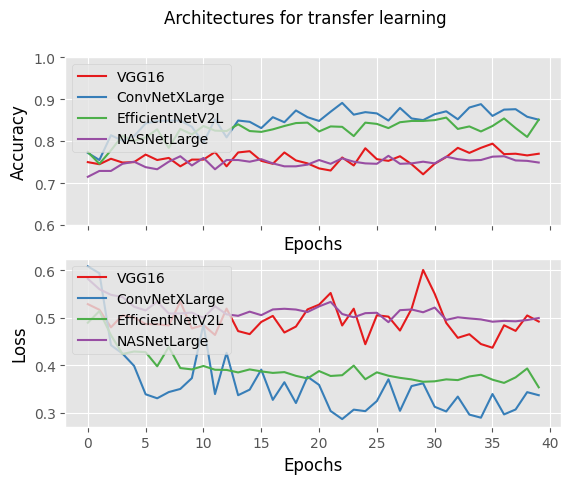

In [47]:
plt.style.use('ggplot')

custom_palette = sns.color_palette("Set1", len(model_names))


# Two subplots, the axes array is 1-d
fig, (ax1,ax2) = plt.subplots(2, sharex=True)

#fig.suptitle('Results with different supernets')

for i in range(len(model_names)):
    ax1.plot(history[i]['val_binary_accuracy'], label=model_names[i],color=custom_palette[i])

ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend(loc='upper left')


ax1.yaxis.label.set_color('black')
ax1.xaxis.label.set_color('black')

ax1.set_ylim(0.6, 1.0)


for i in range(len(model_names)):
    ax2.plot(history[i]['val_loss'], label=model_names[i], color=custom_palette[i])

ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(loc='upper left')

ax2.yaxis.label.set_color('black')
ax2.xaxis.label.set_color('black')

fig.suptitle('Architectures for transfer learning')

plt.savefig('architectures_transfer_learning.pdf', bbox_inches='tight')


plt.show()

## Maximum accuracy reached on the validation set by the supernets

In [49]:
for i in range(len(model_names)):
    print("Maximum accuracy for model ", model_names[i],": ", np.max(history[i]['val_binary_accuracy']))

Maximum accuracy for model  VGG16 :  0.7940000295639038
Maximum accuracy for model  ConvNetXLarge :  0.890999972820282
Maximum accuracy for model  EfficientNetV2L :  0.8560000061988831
Maximum accuracy for model  NASNetLarge :  0.7649999856948853
